**Diplomacy**

Modelo para predecir la intencion de un mensaje entre dos jugadores (verdad o mentira) en el juego de estrategia Diplomacy, para más informacion dirigirse a la [página web](https://sites.google.com/view/qanta/projects/diplomacy?pli=1)

---
Especificaciones: Desarrollado en el ambiente de Google Colab, usando la GPU proporcionada.

Autor: Diego Garcia

## Datos


En primer lugar se importan las librerias necesarias.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel,get_linear_schedule_with_warmup
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from timeit import default_timer as timer

Con base en el [paper](https://users.umiacs.umd.edu/~jbg/docs/2020_acl_diplomacy.pdf) identifique dos puntos principales:


*   Es muy dificil detectar una mentira a partir del mensaje unicamente, es necesario agregar contexto de los mensajes anteriores debido a que es una conversacion
*   El delta de poder del jugador tiene valor al momento de detectar las mentiras ya que representa un indice de la diferencia de poder de los jugadores al momento de enviar el mensaje

Para tener en cuenta esto, la funcion crear_dataset toma la ruta del archivo y genera un dataset que consiste dos columnas:



*   mensaje: El mensaje actual concatenado al delta de poder de los jugadores y ademas con los dos mensajes previos agregados como contexto
*   label: Indica 1 si el mensaje tiene la intencion de ser verdad o 0 si tiene intencion de ser una mentira





In [2]:
def crear_dataset(ruta_archivo):
    messages_list = []
    labels_list = []
    scores_list = []
    with open(ruta_archivo, 'r') as file:
        for line in file:
            data = json.loads(line)
            for i in range(1, len(data['messages']) + 1):
              if data['sender_labels'][i-1] != 'NOANNOTATION':
                contexto = ' '.join(data['messages'][i-2:i-1])
                conversacion = contexto + ' ' + data['messages'][i-1] + ' ' + str(data['game_score_delta'][i-1])
                messages_list.append(conversacion)
                labels_list.append(1 if data['sender_labels'][i-1] == True else 0)

    return pd.DataFrame({'mensaje': messages_list, 'label': labels_list})

In [3]:
archivo_val = '/content/validation.jsonl'
archivo_train = '/content/train.jsonl'
archivo_test = '/content/test.jsonl'

dataset_val = crear_dataset(archivo_val)
dataset_train = crear_dataset(archivo_train)
dataset_test = crear_dataset(archivo_test)

## Exploracion de los datos

Nuestro dataset de entrenamiento tiene mensajes en su mayoria entre 0 y 100 palabras

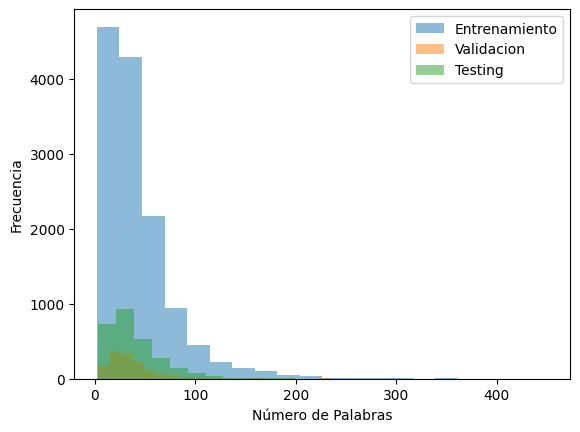

In [4]:
plt.hist(dataset_train['mensaje'].apply(lambda x: len(str(x).split())), bins=20, alpha=0.5, label='Entrenamiento')
plt.hist(dataset_val['mensaje'].apply(lambda x: len(str(x).split())), bins=20, alpha=0.5, label='Validacion')
plt.hist(dataset_test['mensaje'].apply(lambda x: len(str(x).split())), bins=20, alpha=0.5, label='Testing')

# Configurar etiquetas y leyenda
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.legend(loc='upper right')

# Mostrar el gráfico
plt.show()

La observacion mas importante sobre el dataset de entrenamiento, es la distribucion de las clases. Se evidencia un desbalanceo de clases donde los registros que son mentiras solo representan el 5% del dataset

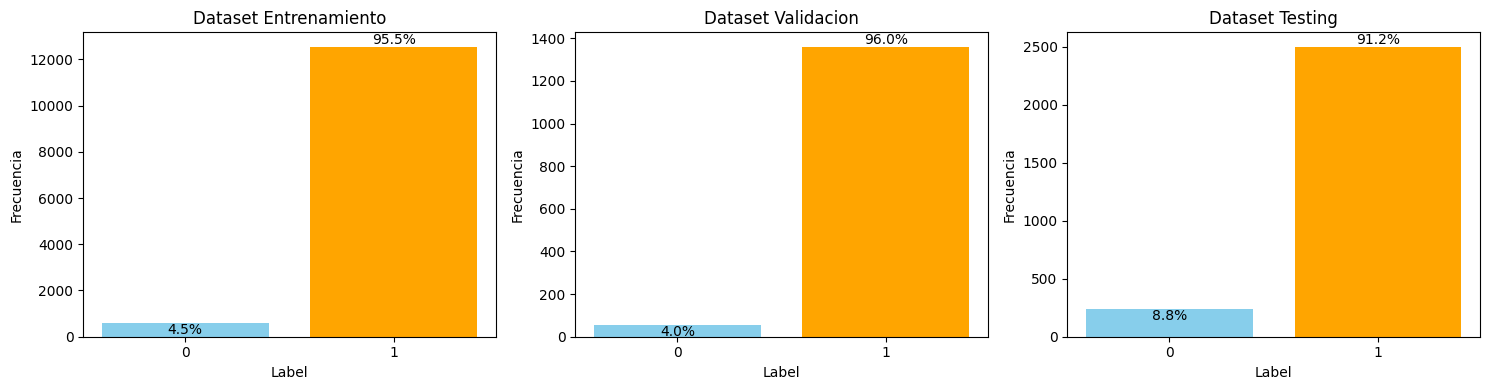

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
nombres = ['Entrenamiento','Validacion','Testing']
# Graficar la frecuencia de la variable "label" en cada conjunto de datos
for i, data in enumerate([dataset_train, dataset_val, dataset_test]):
    counts = data['label'].value_counts().sort_index()
    axs[i].bar(counts.index.astype(str), counts.values, color=['skyblue', 'orange'])
    axs[i].set_title(f'Dataset {nombres[i]}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Frecuencia')

    # Agregar porcentajes
    total = sum(counts)
    for j, count in enumerate(counts):
        percentage = count / total * 100
        axs[i].text(j, count, f'{percentage:.1f}%', ha='center', va='bottom' if j == 1 else 'top', color='black')

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

Para mitigar el desbalanceo, realice under-sampling de la clase mayoritaria (verdades) para tener un nuevo dataset de una distribucion aproximada de 75% - 25% entre las clases

In [6]:
dataset_train_label_0 = dataset_train[dataset_train['label'] == 0]
dataset_train_label_1 = dataset_train[dataset_train['label'] == 1].sample(n=1500, random_state=42)

dataset_train_final = pd.concat([dataset_train_label_0, dataset_train_label_1])

In [17]:
# Mensajes del conjunto de datos
dataset_train_final['mensaje'][:3]

132    You don't want us to fight, yet you betrayed b...
135    Hmmm, should I be reading that as angry sarcas...
139    Well, again, I like that you’re honest with me...
Name: mensaje, dtype: object

## Modelado

Para el clasificador utilice el modelo pre-entrenado [RoBERTa](https://arxiv.org/abs/1907.11692), este modelo es una version optimizada de BERT que es uno de los modelos utilizados en el paper, por esta razon se utilizara en este ejercicio. Para la implementacion es importante tener en cuenta los siguientes puntos:



*   El framework utilizado para la creacion, entrenamiento y prueba del modelo es [PyTorch](https://pytorch.org/)
*   Para la descarga del modelo y tratamiento de los datos se utiliza la libreria [transformers](https://huggingface.co/docs/transformers/index) desarrollada por [HuggingFace](https://huggingface.co/)
*   El tamaño de batch de entrenamiento es de 16





In [8]:
# Tokenizador
nombre_modelo = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(nombre_modelo)

def tokenize_data(df,batch_size=16):
    tokenized_texts = []
    attention_masks = []

    for text in df['mensaje']:
        # Tokenizar el mensaje
        tokens = tokenizer.encode(str(text),truncation=True, max_length=512)

        # Asegurar que la secuencia no sea más larga de 512 tokens tomando solo los últimos 512 tokens
        if len(tokens) > 512:
            tokens = tokens[-512:]

        # Crear máscara de atención
        attention_mask = [1] * len(tokens)

        # Padding si es necesario
        if len(tokens) < 512:
            tokens += [0] * (512 - len(tokens))
            attention_mask += [0] * (512 - len(attention_mask))

        tokenized_texts.append(tokens)
        attention_masks.append(attention_mask)

    # Convertir a tensores de PyTorch
    input_ids = torch.tensor(tokenized_texts)
    attention_mask = torch.tensor(attention_masks)
    labels = torch.tensor(df['label'].values, dtype=torch.float32)

    # Creacion del dataloader para el entrenamiento, validacion y test
    dataset = TensorDataset(input_ids, attention_mask, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Dataloaders del conjunto de entrenamiento y validacion
train_dataloader = tokenize_data(dataset_train_final)
val_dataloader = tokenize_data(dataset_val)


In [9]:
# Uso de GPU si es posible en el ambiente
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Para la transferencia de aprendizaje del modelo pre-entrenado, se crea la siguiente clase que utiliza el modelo, agrega una capa de dropout y finalmente una capa densa con una sola unidad de procesamiento como salida. No utilizo una funcion Sigmoide como salida por que en el ciclo de entrenamiento se emplea una funcion de perdida que ya tiene implementada esta funcion.

Al final se imprime la estructura del modelo utilizado en este ejercicio.

In [10]:
class ClasificadorTransformer(nn.Module):
    def __init__(self):
        super(ClasificadorTransformer, self).__init__()
        self.modelo_transformer = AutoModel.from_pretrained(nombre_modelo)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.modelo_transformer(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0]
        x = self.dropout(x)
        x = self.linear(x)
        return x

# Crear el modelo
model = ClasificadorTransformer()
model.to(device)

# Ver la estructura del modelo
print(model)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ClasificadorTransformer(
  (modelo_transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

Para el ciclo de entrenamiento se utilizan los siguientes parametros:



*   Epocas: 5
*   Learning rate: 0.00002
*   Funcion de perdida: BCEWithLogitsLoss
*   Metricas de evaluacion: Accuracy y F1-Score Macro utilizado en el paper



In [11]:
# Optimizador
epochs = 5
lr=0.00002
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=0.01)

# Calculo de peso de clases para castigar mas al modelo cuando clasifica mal una mentira

num_positives = dataset_train_final['label'].sum()
num_negatives = len(dataset_train_final['label']) - num_positives
pos_weight  = num_negatives / num_positives

# Función de pérdida

criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(pos_weight).to(device))

# Ciclo de entrenamiento
inicio = timer()
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Reiniciar gradientes
        optimizer.zero_grad()

        # Propagación hacia adelante
        outputs = model(input_ids, attention_mask).to(device)
        labels = labels.unsqueeze(1)
        loss = criterion(outputs, labels.float())

        # Propagación hacia atrás y actualización de parámetros
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Ciclo de validacion
    predictions = []
    actual_labels = []
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask)
            out = (outputs>0.0).float()
            predictions.extend(out.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    acc = accuracy_score(actual_labels, predictions)
    f1 = f1_score(actual_labels, predictions, average='macro')
    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}, Accuracy Val: {acc:.4f}, F1-Macro Val: {f1:.4f}')
final = timer()
tiempo = final - inicio
print(f'Tiempo de entrenamiento: {tiempo:.2f}')

0.394
Epoch 1/5, Loss: 0.3924, Accuracy Val: 0.9541, F1-Macro Val: 0.4883
Epoch 2/5, Loss: 0.3881, Accuracy Val: 0.4336, F1-Macro Val: 0.3389
Epoch 3/5, Loss: 0.3774, Accuracy Val: 0.8814, F1-Macro Val: 0.5396
Epoch 4/5, Loss: 0.3635, Accuracy Val: 0.5812, F1-Macro Val: 0.4209
Epoch 5/5, Loss: 0.3544, Accuracy Val: 0.8037, F1-Macro Val: 0.5232
Tiempo de entrenamiento: 357.75


## Test

In [12]:
# Creacion del dataloader del conjunto de datos test
test_dataloader = tokenize_data(dataset_test)

En las metricas de test resultantes se pueden destacar los siguientes datos:


*   El valor de F1-Score macro indica que el modelo esta a la par del mejor modelo propuesto en el paper, sin embargo no presenta una mejora de este.
*   El modelo identifica exitosamente el 40% de las mentiras en el conjunto de prueba, sin embargo presenta un alto indice de falsas mentiras (verdades clasificadas erroneamente)

Posibles mejoras:



*   Probar otras alternativas a las planteadas en este ejercicio para el manejo de desbalanceo de clases
*   Modificar el umbral de clasificacion del modelo para tener predicciones mas precisas
*   Aumentar la complejidad del modelo para identificar los patrones mas complicados en los datos







F1-Macro: 0.5632


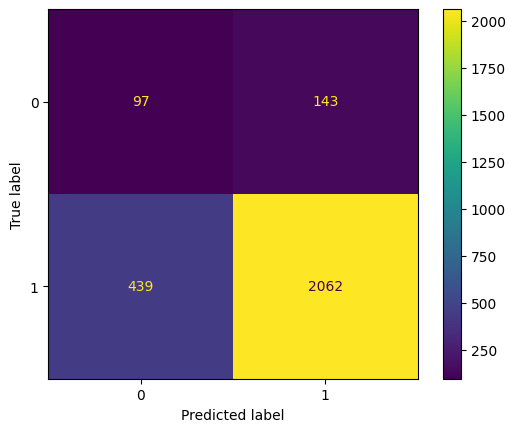

In [18]:
predictions = []
actual_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask)
        out = (outputs>0.0).float()
        predictions.extend(out.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())
f1 = f1_score(actual_labels, predictions, average='macro')
print(f'F1-Macro: {f1:.4f}')
cm = confusion_matrix(actual_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [19]:
torch.save(model, 'modelo_Diplomacy.pt')